<a href="https://colab.research.google.com/github/kshakib22/Newspaper-image-segmentation/blob/main/Template_Matching_%2B_Masking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!pip install opencv-python
!pip install opencv-contrib-python
!pip install pytesseract
!apt-get install tesseract-ocr
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2build2).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.
Mounted at /content/drive


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
from PIL import Image
import urllib.request

# OpenCV EAST text detector

In [ ]:
!wget https://raw.githubusercontent.com/oyyd/frozen_east_text_detection.pb/master/frozen_east_text_detection.pb

In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def visualize_text_boxes(image_path, confidence_threshold=0.5):
    # Load the EAST text detector model
    net = cv2.dnn.readNet("frozen_east_text_detection.pb")

    # Set CUDA as the preferable backend and target for GPU acceleration
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

    # Load the input image
    image = cv2.imread(image_path)

    # Preprocess the image
    blob = cv2.dnn.blobFromImage(image, 1.0, (320, 320), (123.68, 116.78, 103.94), True, False)

    # Set the blob as input to the network and perform a forward pass
    net.setInput(blob)
    scores, geometry = net.forward(["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"])

    # Decode the predictions and filter based on confidence threshold
    boxes, confidences = decode_predictions(scores, geometry, confidence_threshold)

    # Iterate over the detected boxes and draw rectangles around the text
    for box in boxes:
        x, y, w, h = box
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Convert BGR image to RGB for visualization in Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image with text boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

def decode_predictions(scores, geometry, confidence_threshold):
    # Get the number of rows and columns from the scores
    num_rows, num_cols = scores.shape[2:4]

    # Decode the predictions
    boxes = []
    confidences = []
    for y in range(num_rows):
        scores_data = scores[0, 0, y]
        x_data0 = geometry[0, 0, y]
        x_data1 = geometry[0, 1, y]
        x_data2 = geometry[0, 2, y]
        x_data3 = geometry[0, 3, y]
        angles_data = geometry[0, 4, y]

        for x in range(num_cols):
            score = scores_data[x]
            if score < confidence_threshold:
                continue

            offset_x = x * 4.0
            offset_y = y * 4.0

            angle = angles_data[x]
            cos_a = np.cos(angle)
            sin_a = np.sin(angle)

            h = x_data0[x] + x_data2[x]
            w = x_data1[x] + x_data3[x]

            end_x = int(offset_x + (cos_a * x_data1[x]) + (sin_a * x_data2[x]))
            end_y = int(offset_y - (sin_a * x_data1[x]) + (cos_a * x_data2[x]))
            start_x = int(end_x - w)
            start_y = int(end_y - h)

            boxes.append((start_x, start_y, int(w), int(h)))
            confidences.append(float(score))

    return boxes, confidences



In [ ]:
# Call the function to detect text and column in an image
image_path = '/content/drive/MyDrive/Summer 2023 project/Images/charter1.jpg'
east_model_path = 'frozen_east_text_detection.pb'
visualize_text_boxes(image_path, confidence_threshold=0.1)

# PDF to image conversion
The main purpose of adding in-code pdf to image conversion is the code works accurately only when all images are converted at the same DPI and format. This means the template needs to be extrtacted from one of the converted image as well.

In [ ]:
!pip install pdf2image Pillow
!apt-get install poppler-utils


In [22]:
from pdf2image import convert_from_path
import os
from pdf2image import convert_from_path

# Folder path containing PDF files
pdf_folder = '/content/drive/MyDrive/Summer 2023 project/Images/single_pdfs'

# Output path for saving the images
output_path = '/content/drive/MyDrive/Summer 2023 project/Images/'

# Iterate over PDF files in the folder
for filename in os.listdir(pdf_folder):
    if filename.endswith('.pdf'):
        # Construct full paths for input PDF and output image
        pdf_path = os.path.join(pdf_folder, filename)
        image_name = os.path.splitext(filename)[0] + '.jpg'
        image_path = os.path.join(output_path, image_name)

        # Convert PDF pages to PIL images
        images = convert_from_path(pdf_path, dpi=300, grayscale=False)

        # Save each image as JPEG with original PDF name
        for i, image in enumerate(images):
            image.save(f'{image_path}_{i}.jpg', 'JPEG')



# OpenCV template matching

In [23]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def find_template(image_path, template_path):
    # Load the images
    image = cv2.imread(image_path)
    template = cv2.imread(template_path)

    # Convert images to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

    # Perform template matching
    result = cv2.matchTemplate(gray_image, gray_template, cv2.TM_CCOEFF_NORMED)
    _, max_val, _, max_loc = cv2.minMaxLoc(result)

    # Define the bounding box around the best match
    h, w = gray_template.shape
    top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    # Draw the bounding box on the image
    matched_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cv2.rectangle(matched_image, top_left, bottom_right, (0, 255, 0), 2)

    # Display the result
    plt.figure(figsize=(15, 15))
    save_name = input("Input save file name: ")
    plt.imsave(f"/content/drive/MyDrive/Summer 2023 project/Images/{save_name}.jpg", matched_image)
    plt.imshow(matched_image)
    plt.axis('off')
    plt.show()

Input save file name: test_charter1


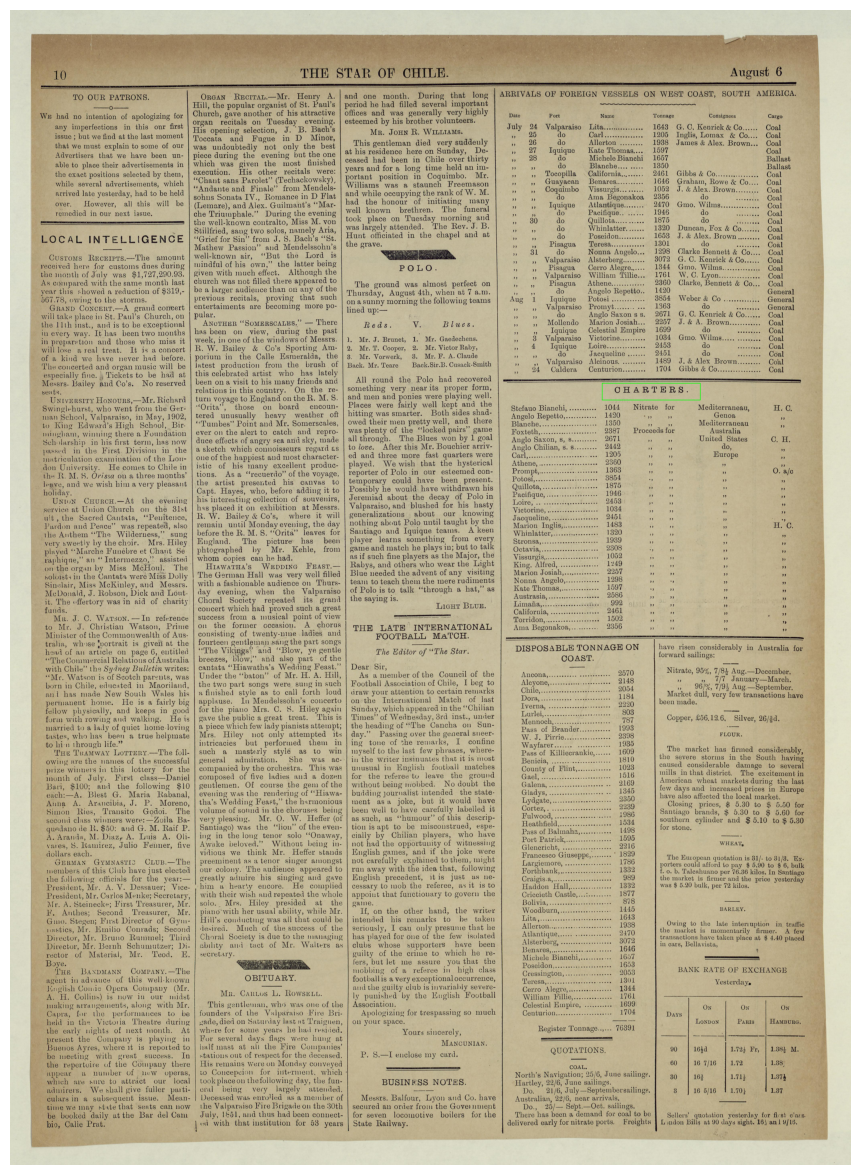

In [24]:
# Call the function to perform template matching
template_path = "/content/drive/MyDrive/Summer 2023 project/Images/template.jpg"
image_path = '/content/drive/MyDrive/Summer 2023 project/Images/charter1.jpg'
find_template(image_path, template_path)

# Second Matching

Input save file name: test_charter2


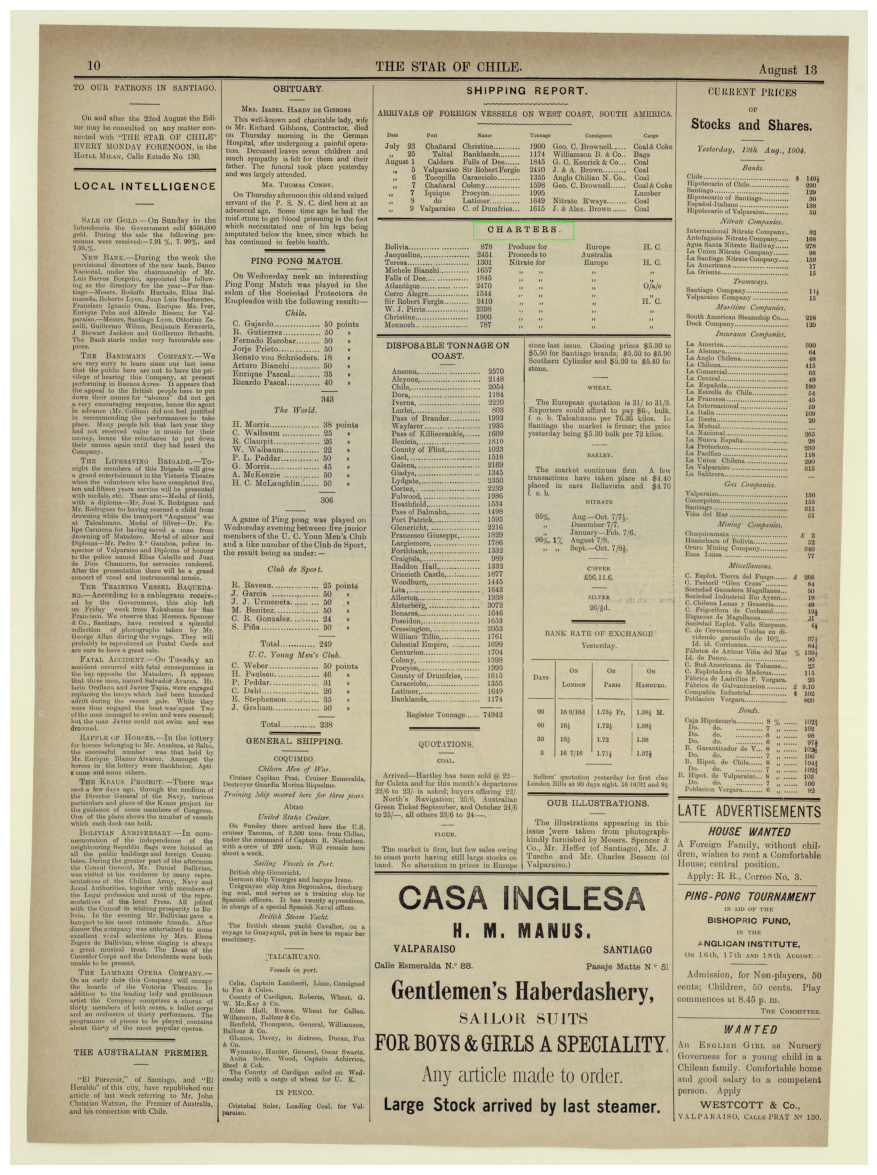

In [25]:
# template matching on a different image
image_path2 = '/content/drive/MyDrive/Summer 2023 project/Images/charter2.jpg'
find_template(image_path2, template_path)


# Third Matching

Input save file name: test_charter3


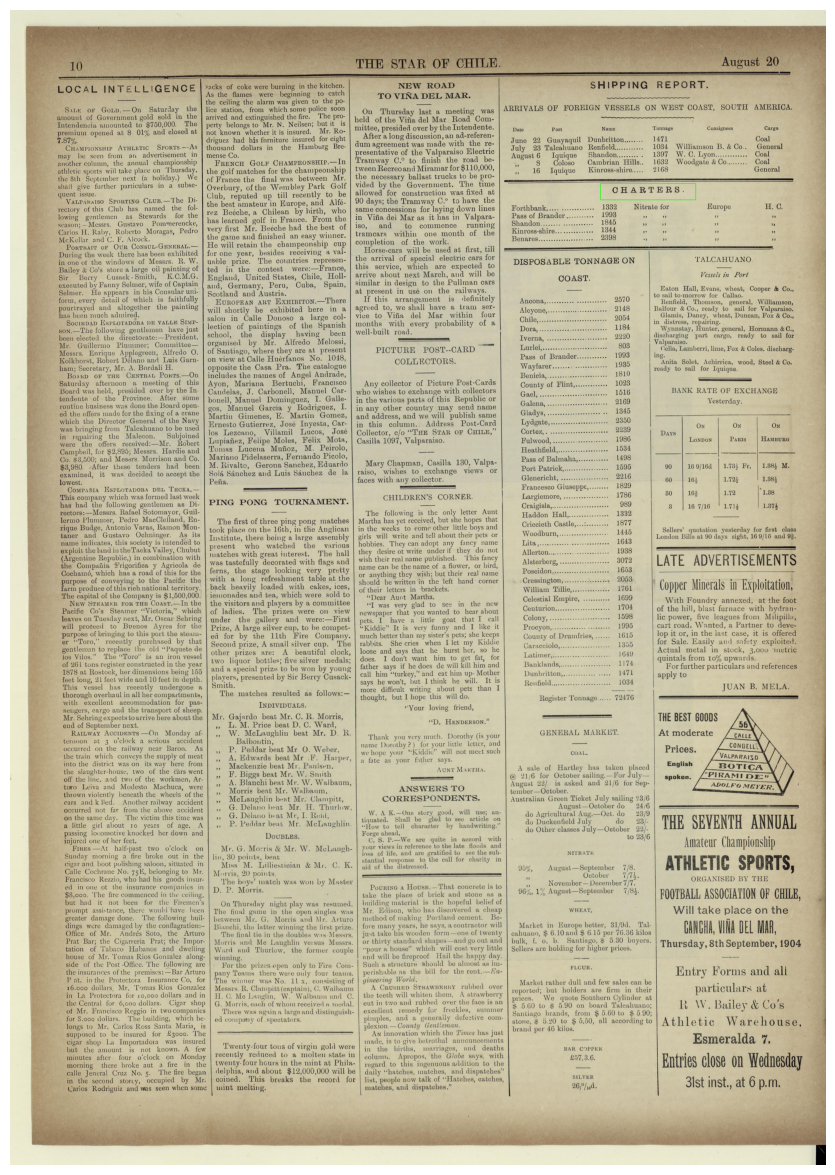

In [26]:
# template matching on third image
image_path3 = '/content/drive/MyDrive/Summer 2023 project/Images/charter3.jpg'
find_template(image_path3, template_path)

# Masking after matching

In [11]:
# URL of the configuration file
url_config = 'https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/yolov4.cfg'
url_weights = 'https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights'

# Local path to save the file
save_path_config = '/content/yolov4.cfg'
save_path_weights= '/content/yolov4.weights'


# Download the file
urllib.request.urlretrieve(url_config, save_path_config)
urllib.request.urlretrieve(url_weights, save_path_weights)

('/content/yolov4.weights', <http.client.HTTPMessage at 0x7f8e244850f0>)

In [25]:
# Load the pre-trained YOLOv4 files (weights and configuration)
weights_path = save_path_weights
config_path = save_path_config

# Load the pre-trained model
net = cv2.dnn.readNetFromDarknet(config_path, weights_path)

# Set preferable target to CUDA (GPU)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

# Specify the target output layer names
output_layer_names = net.getLayerNames()
output_layer_names = [output_layer_names[i - 1] for i in net.getUnconnectedOutLayers()]



# Load the image
image = cv2.imread("/content/drive/MyDrive/Summer 2023 project/Images/test.jpg")

# Perform object detection
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
net.setInput(blob)
layer_outputs = net.forward(output_layer_names)

# Extract bounding boxes, confidences, and class IDs
boxes = []
confidences = []
class_ids = []
(H, W) = image.shape[:2]

for output in layer_outputs:
    for detection in output:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]

        if confidence > 0.5 and class_id == 0:  # Assuming class_id 0 represents the desired object
            box = detection[0:4] * np.array([W, H, W, H])
            (center_x, center_y, width, height) = box.astype("int")

            x = int(center_x - (width / 2))
            y = int(center_y - (height / 2))

            boxes.append([x, y, int(width.item()), int(height.item())])
            confidences.append(float(confidence))
            class_ids.append(class_id)

# Apply non-maxima suppression to eliminate redundant overlapping boxes
if len(boxes) > 0:
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.3)

    # Mask the region of interest (ROI)
    if len(indices) > 0:
        roi_mask = np.zeros_like(image)
        for i in indices.flatten():
            x, y, w, h = boxes[i]
            roi_mask[y:y+h, x:x+w] = image[y:y+h, x:x+w]

        # Apply the mask to the original image
        masked_image = cv2.bitwise_and(image, roi_mask)

        # Convert BGR to RGB for Matplotlib
        image_rgb = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)

        # Display the masked image
        plt.imshow(image_rgb)
        plt.axis('off')
        plt.show()
    else:
        print("No matching object found.")
else:
    print("No objects detected.")



No objects detected.


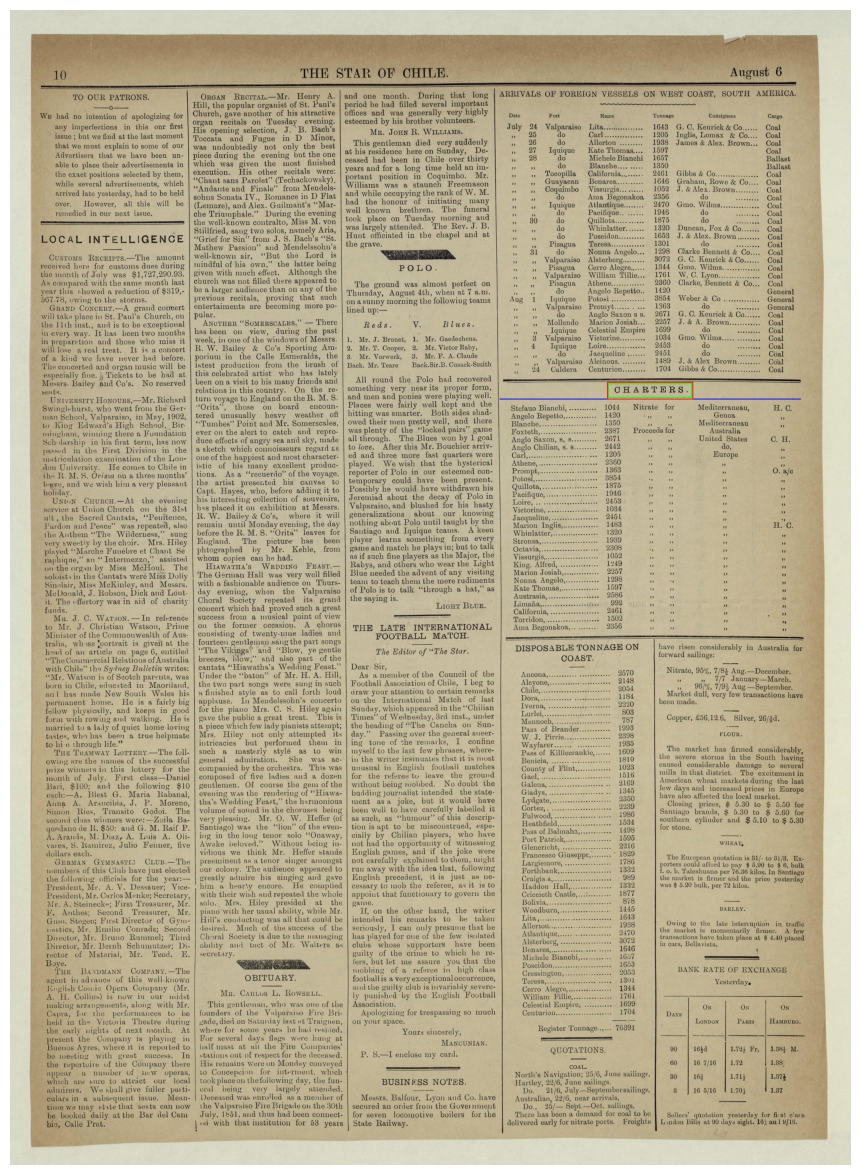

Length of the bottom of the rectangle: 284
Lower-left coordinate: (1989, 1296)
Lower-right coordinate: (2273, 1296)
Transform factor: 359
New lower-left coordinate: (1630, 1296)
New lower-right coordinate: (2632, 1296)


In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the pre-trained model
net = cv2.dnn.readNetFromDarknet(config_path, weights_path)

# Load the image
image = cv2.imread("/content/drive/MyDrive/Summer 2023 project/Images/test.jpg")

# Convert BGR image to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the lower and upper bounds for green color in HSV
lower_green = np.array([40, 40, 40])
upper_green = np.array([70, 255, 255])

# Threshold the image to get a binary mask of the green color regions
mask = cv2.inRange(hsv, lower_green, upper_green)

# Find contours of the green regions in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Iterate over the contours and find the bounding box of the largest contour
largest_contour = max(contours, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(largest_contour)

# Calculate the coordinates of the lower-left and lower-right corners
lower_left = (x, y + h)
lower_right = (x + w, y + h)

# Calculate the transform factor
transform_factor = int(w * 1.266)

# Move the lower-left coordinate to the left by the transform factor
new_lower_left = (lower_left[0] - transform_factor, lower_left[1])

# Move the lower-right coordinate to the right by the transform factor
new_lower_right = (lower_right[0] + transform_factor, lower_right[1])

# Draw a blue line between the new coordinates
cv2.line(image, new_lower_left, new_lower_right, (255, 0, 0), 2)

# Draw a red rectangle around the detected green box
cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 255), 2)

# Convert BGR image to RGB for displaying with Matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image with the detected green box
plt.figure(figsize=(15, 15))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

# Print the calculated variables
print("Length of the bottom of the rectangle:", w)
print("Lower-left coordinate:", lower_left)
print("Lower-right coordinate:", lower_right)
print("Transform factor:", transform_factor)
print("New lower-left coordinate:", new_lower_left)
print("New lower-right coordinate:", new_lower_right)
